# Data Access on the Planetary Computer

In this notebook, we'll take a whirlwind tour of accessing geospatial data in many flavors. A few things to note as we go through it:

1. We'll be using cloud-friendly formats
    - We'll stream the data directly from Blob Storage into memory. No downloading to local disk!
2. We'll always start with the STAC API
    - No need to remember URLs / paths in blob storage
    
We'll do some light computations and analysis, just to get a feel for how data access leads into those workloads. But the emphasis will be on that starting point of "how do I get the data I care about?"

If you're curiuos about all the different datasets made available through the Planetary Computer, visit the catalog https://planetarycomputer.microsoft.com/catalog.

In [1]:
import os
os.environ["USE_PYGEOS"] = "0"

import urllib.request
import operator
import functools
import warnings
import requests
import datetime

import dask.distributed
import pystac_client
import planetary_computer
import stackstac
import numpy as np
import geopandas
import dask.dataframe
import dask_geopandas
import fsspec
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import pyproj
import pdal
import shapely.geometry
import shapely.ops
import odc.stac


warnings.filterwarnings("ignore", message="The argument 'infer_datetime_format'", category=UserWarning)

We'll make a [`pystac_client.Client`](https://pystac-client.readthedocs.io/) to interact with the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/docs/reference/stac/). All of the data we access will be through the STAC catalog, freeing us from having to think about files and paths.

Whenever you're working with the Planetary Computer, you need to "sign" your items / assets. This appends a read-only [SAS token](https://learn.microsoft.com/en-us/azure/storage/common/storage-sas-overview) to the data so that we can fetch the data from Blob Storage.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

And we'll make a local Dask "cluster" to do some computations in parallel.

In [3]:
dask_client = dask.distributed.Client()
dask_client

<Client: 'tcp://127.0.0.1:40977' processes=4 threads=8, memory=7.50 GiB>

## Types of Geospatial Data

The geospatial world typically distinguishes between *raster* and *vector* data. Raster data are gridded, n-dimensional arrays (think of satellite imagery, climate or weather model output, land cover models, etc.). The "pixels" (elements of the n-dimensional array) are the observations or forecasts or whatever is being measured.

Vector data are things like Points, Lines, and Polygons. Think of administrative boundaries or building footprints.

The Planetary Computer hosts both. All of the files will be in Azure Blob Storage, the scalable storage service we discussed previously. We'll discover all the data via STAC, which will give us the URLs of the actual files, and will stream the data directly into memory as much as possible.

## Raster Data (imagery, land use, elevation, etc)

Raster data is often stored as Cloud Optimized GeoTIFF. Some examples include

* Satellite imagery / aerial photography
    - [Landsat C2-L2](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2)
    - [Sentinel 2 L2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
    - [NAIP](https://planetarycomputer.microsoft.com/dataset/naip)
    - [GOES-CMI](https://planetarycomputer.microsoft.com/dataset/goes-cmi)
* Land use / land cover
    - [Esri / IO 10-Meter Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class)
    - [Land Cover of Canada](https://planetarycomputer.microsoft.com/dataset/nrcan-landcover)
* Elevation Models
    - [COP DEM](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30)
    - [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem)
* "Derived variables"
    - [Chloris Biomass](https://planetarycomputer.microsoft.com/dataset/chloris-biomass)
    - [HGB](https://planetarycomputer.microsoft.com/dataset/hgb)
    - [HREA](https://planetarycomputer.microsoft.com/dataset/hrea)



Let's start by loading up some [GOES-CMI](https://planetarycomputer.microsoft.com/dataset/goes-cmi) imagery. We'll search for images from a particular time and area, which I happen to know covers the path [Hurricane Florence](https://en.wikipedia.org/wiki/Hurricane_Florence) took.

In [4]:
bbox = [-67.273, 25.600, -61.800, 27.542]
start = datetime.datetime(2018, 9, 11, 13, 0, 0, tzinfo=datetime.timezone.utc)
stop = datetime.datetime(2018, 9, 11, 15, 40, 0, tzinfo=datetime.timezone.utc)

GOES imagery comes in three flavors:

1. Full Disk (half of the earth)
2. CONUS (the continental United States)
3. Mesoscale (focused on a small area)

We'll grab the mesoscale imagery by querying on the `goes:image-type` field in the STAC metadata:

In [5]:
search = catalog.search(
    bbox=bbox,
    datetime=[start, stop],
    collections=["goes-cmi"],
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)
items = search.item_collection()
items

Many items in the Planetary Computer include a "rendered_preview" asset, which uses the Planetary Computer's [`data` API](https://planetarycomputer.microsoft.com/docs/quickstarts/using-the-data-api/) to dynamically read and render the asset.

This gives a quick way to visualize the data, without having to set up your own compute (if you're embedding this in a website, for example). The Planetary Computer's already done that work of reading the raw data and turning it into an image.

In [6]:
from IPython.display import Image

print(items[0].assets["rendered_preview"].href)

Image(url=items[0].assets["rendered_preview"].href)

https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=goes-cmi&item=OR_ABI-L2-M1-M3_G16_s20182541539210&expression=C02_2km_wm%3B0.45%2AC02_2km_wm%2B0.1%2AC03_2km_wm%2B0.45%2AC01_2km_wm%3BC01_2km_wm&nodata=-1&rescale=1%2C1000&color_formula=Gamma+RGB+2.5+Saturation+1.4+Sigmoidal+RGB+2+0.7&asset_as_band=True&resampling=bilinear&format=png


But, let's suppose that we want to do some fancier analysis. We can load it into an [xarray Dataset](https://docs.xarray.dev/en/stable/), which lets us work with a group of aligned datacubes.

We'll use [odc-stac](https://odc-stac.readthedocs.io/) to quickly translate from the list of STAC items to an xarray Dataset.

In [7]:
# blue, red, and near-infrared bands
bands = ["C01_2km", "C02_2km", "C03_2km"]
goes = odc.stac.stac_load(
    items,
    bands=bands,
    chunks={},
).where(lambda x: x > -1)   # filter out "nodata" values

# Use the common names for labels
band_to_common_name = {
    k: items[0].assets[k].to_dict()["eo:bands"][0]["common_name"] for k in bands
}
goes = goes.rename_vars(band_to_common_name)
goes

<xarray.Dataset>
Dimensions:      (time: 160, y: 501, x: 501)
Coordinates:
  * y            (y) float64 3.368e+06 3.366e+06 ... 2.368e+06 2.366e+06
  * x            (x) float64 3.196e+05 3.216e+05 ... 1.32e+06 1.322e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2018-09-11T13:00:21 ... 2018-09-11T15:...
Data variables:
    blue         (time, y, x) float64 dask.array<chunksize=(1, 501, 501), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 501, 501), meta=np.ndarray>
    nir09        (time, y, x) float64 dask.array<chunksize=(1, 501, 501), meta=np.ndarray>

You can click on the "data" icon next to each Data Variable to get a visual representation of each cube.

We can quickly plot the blue band for the first timestamp.

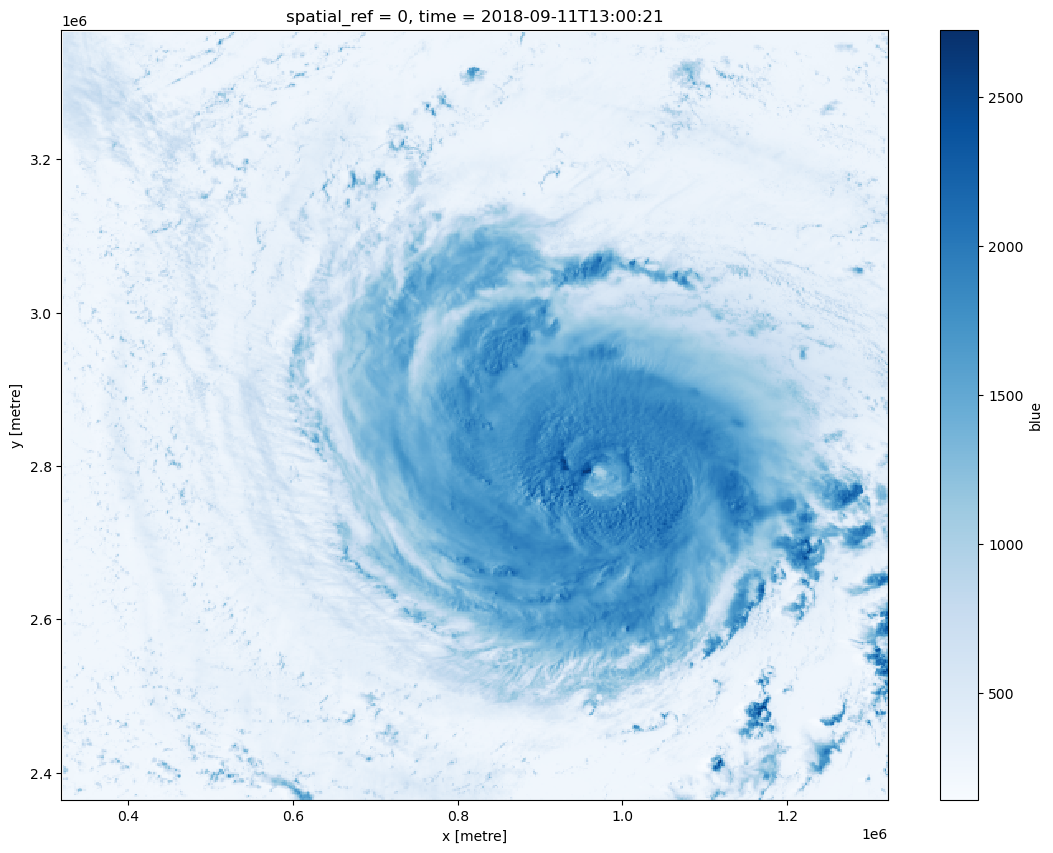

In [8]:
goes["blue"].isel(time=0).plot.imshow(cmap="Blues", size=10);

GOES-CMI doesn't capture a green band. If we want to make a true-color image, we'll need to combine the blue, red, and near-infrared bands.

In [9]:
goes["green"] = 0.45 * goes["red"] + 0.1 * goes["nir09"] + 0.45 * goes["blue"]

rgb = (
    goes[["red", "green", "blue"]]
        .to_array(dim="band")
        .transpose("time", "band", "y", "x")
        .sel(band=["red", "green", "blue"])
)
rgb /= rgb.max(dim=["band", "y", "x"])
rgb

<xarray.DataArray (time: 160, band: 3, y: 501, x: 501)>
dask.array<truediv, shape=(160, 3, 501, 501), dtype=float64, chunksize=(1, 1, 501, 501), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.368e+06 3.366e+06 ... 2.368e+06 2.366e+06
  * x            (x) float64 3.196e+05 3.216e+05 ... 1.32e+06 1.322e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2018-09-11T13:00:21 ... 2018-09-11T15:...
  * band         (band) object 'red' 'green' 'blue'

Here's the RGB image, brighted up a bit with a gamma correction.

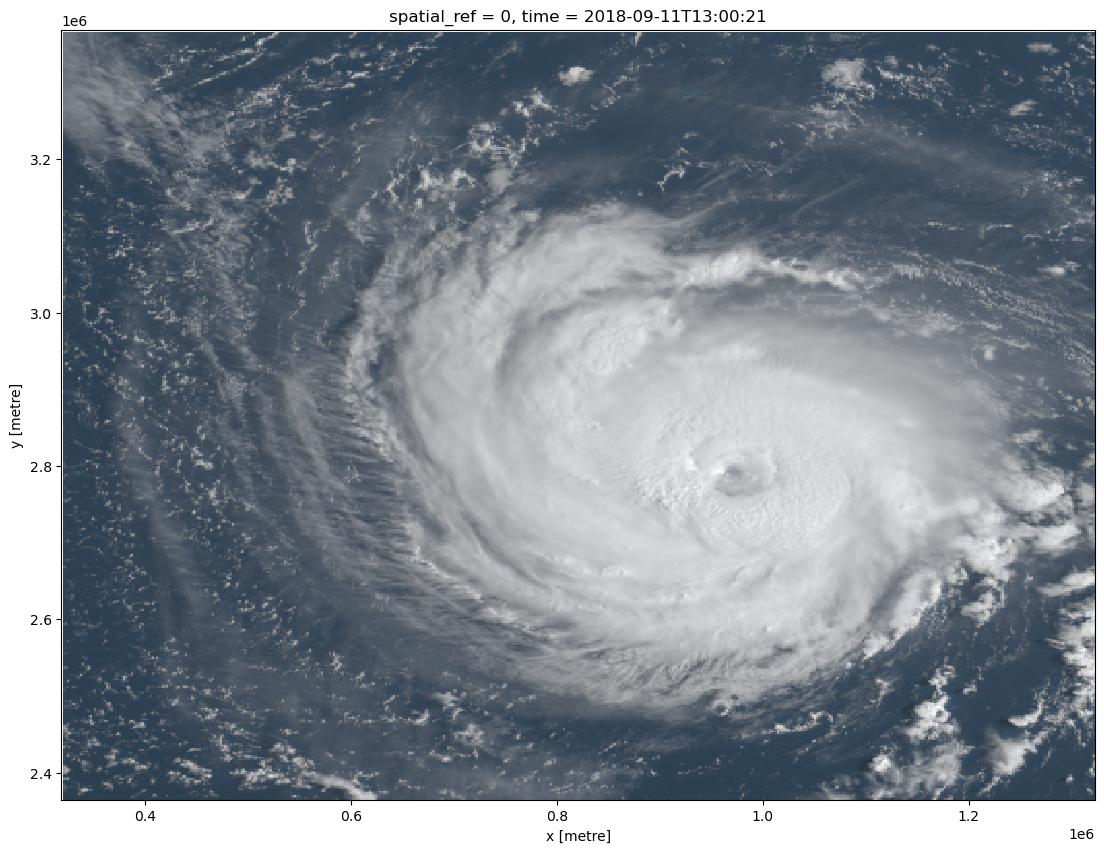

In [10]:
warnings.filterwarnings("ignore", message="invalid value")

(rgb.isel(time=0) ** (1 / 2.2)).clip(0, 1).plot.imshow(size=10);

Check out the [full tutorial](https://planetarycomputer.microsoft.com/docs/tutorials/hurricane-florence-animation/) on how to make an animation from that timeseries of GOES-CMI images.

This example showed:

1. Using the STAC API to query for GOES-CMI imagery over particular area and time.
2. Loading the matched imagery data into an xarray Dataset for analysis.

### Land Use / Land Cover

Land Use / Land Cover maps are another example of raster data. The "pixels" aren't imagery. Instead they're classes assigned by some process. Here, we'll use the [NOAA C-CAP](https://planetarycomputer.microsoft.com/dataset/noaa-c-cap) dataset.

We can use the Planetary Computer's `data` API to quickly visualize this kind of data.

In [11]:
from IPython.display import IFrame

ccap = next(catalog.get_collection("noaa-c-cap").get_all_items())
link = ccap.get_single_link(rel="preview").href
print(link)
IFrame(link, 1200, 800)

https://planetarycomputer.microsoft.com/api/data/v1/item/map?collection=noaa-c-cap&item=conus_2016_ccap_landcover_20200311


The `ccap.assets["data"].extra_fields` object in the STAC metadata has the information on the different values and their meaning.

In [12]:
ccap.assets["data"].extra_fields["classification:classes"][:4]

[{'value': 0, 'description': 'Background'},
 {'value': 1, 'description': 'Unclassified (Cloud, Shadow, etc)'},
 {'value': 2,
  'color-hint': 'FFFFFF',
  'description': 'High Intensity Developed'},
 {'value': 3,
  'color-hint': 'C1C1C1',
  'description': 'Medium Intensity Developed'}]

Check out [C-CAP in the Explorer](https://planetarycomputer.microsoft.com/explore?c=-80.9692%2C26.7407&z=7.00&v=2&d=noaa-c-cap&m=All+years&r=Classification&s=false%3A%3A100%3A%3Atrue&sr=desc&ae=0), which uses the same technique to render the values. It also uses another API endpoint to overlay a legend with the class names and colormap.

### Earth systems data (also raster)

In the climate and weather community, you might hear about "earth systems" data. These datasets are typically stored as Zarr or NetCDF.

* Climate model output
    - Terraclimate, gridMet, Daymet, NEX-GDDP-CMIP6
* Weather forecast
    - ecmwf-forecast
* Reanalysis
    - ERA5
* Observations
    - GPM IMERG

Analysis of these kinds of data will be pretty similar to other raster data. But one key characteristic of earth systems data is you'll often get long time-series: you'll have very many temporal observations that use the exact same spatial grid.

In this example, we'll load up some data from Terraclimate, stored as Zarr.

In [13]:
terraclimate = catalog.get_collection("terraclimate")
asset = terraclimate.assets["zarr-abfs"]

ds = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:  (time: 768, lat: 4320, lon: 8640, crs: 1)
Coordinates:
  * crs      (crs) int16 3
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2021-12-01
Data variables: (12/14)
    aet      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    def      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pdsi     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pet      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ppt      (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    q        (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ...       ...
    swe      (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmax     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmin     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vap      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vpd      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ws       (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                     CF-1.6
    acknowledgment:                  Please cite the references included here...
    cdm_data_type:                   GRID
    contributor_email:               khegewisch@ucmerced.edu
    contributor_name:                Katherine Hegewisch
    contributor_role:                Postdoctoral Fellow
    ...                              ...
    time_coverage_duration:          P1Y
    time_coverage_end:               1958-12-01T00:0
    time_coverage_resolution:        P1M
    time_coverage_start:             1958-01-01T00:0
    title:                           TerraClimate: monthly climate and climat...
    version:                         v1.0

Notice the long timeseries for each data variable, like `tmax`. We can slice down to a subset of the data (in both time and space), and compute the average temperature.

In [14]:
%%time

tmax = ds["tmax"].sel(
    time=slice("1965", None),
    lon=slice(-127, -66),
    lat=slice(49, 21)
).mean(dim=("lat", "lon")).compute()

CPU times: user 2.61 s, sys: 679 ms, total: 3.29 s
Wall time: 15.1 s


One important note: this Zarr dataset contains many variables, and the arrays for each variable are larger than what we'll work with here. We crucially only loaded the data within the `tmax` variable, and only the chunks of the data falling inside our temporal and spatial subset.

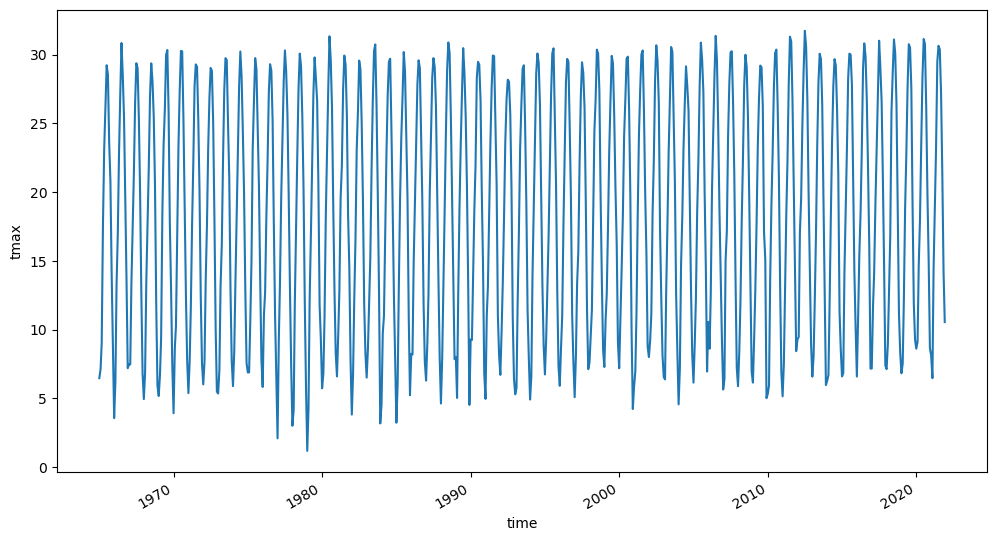

In [15]:
tmax.plot(size=6, aspect=2);

## Exercise

Use xarray's `groupby` method group that on `tmax` timeseries to make a timeries plot of average temperature by year.

- Hint: Check the docstring with `tmax.groupby?`, or view [the docs](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html).
- Hint: you can pass a string like `"<dimension>.<frequency>"` to specify the dimension name and temporal frequency you want to group by.

In [ ]:
# Your solution here
tmax.groupby(...)

Execute the next cell to load a potential solution, and execute it again to run the solution.

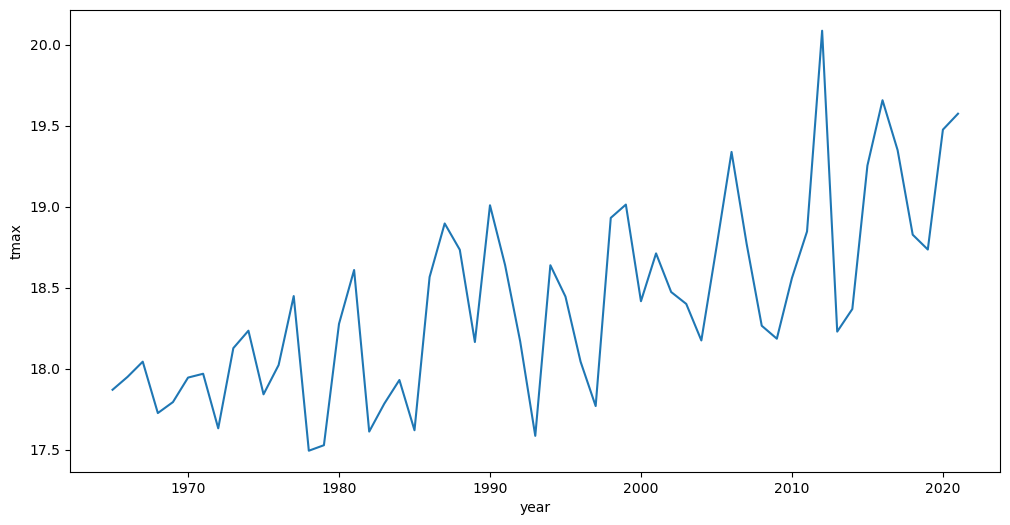

In [17]:
%load exercise_01.py

NOAA's [Optimum Interpolation Sea Surface Temperature](https://planetarycomputer.microsoft.com/dataset/noaa-cdr-sea-surface-temperature-optimum-interpolation) (OISST) dataset is a another example.

In [18]:
item_search = catalog.search(
    collections="noaa-cdr-sea-surface-temperature-optimum-interpolation",
    datetime="2023"
)
items = list(item_search.items())
len(items)

354

In [19]:
oisst = odc.stac.load(items, bands=["sst", "ice", "err", "anom"], chunks={}).where(lambda x: x > -999)
oisst

<xarray.Dataset>
Dimensions:      (time: 354, latitude: 720, longitude: 1440)
Coordinates:
  * latitude     (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude    (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-21
Data variables:
    sst          (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ice          (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err          (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anom         (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

We can make a plot of a single time slice,

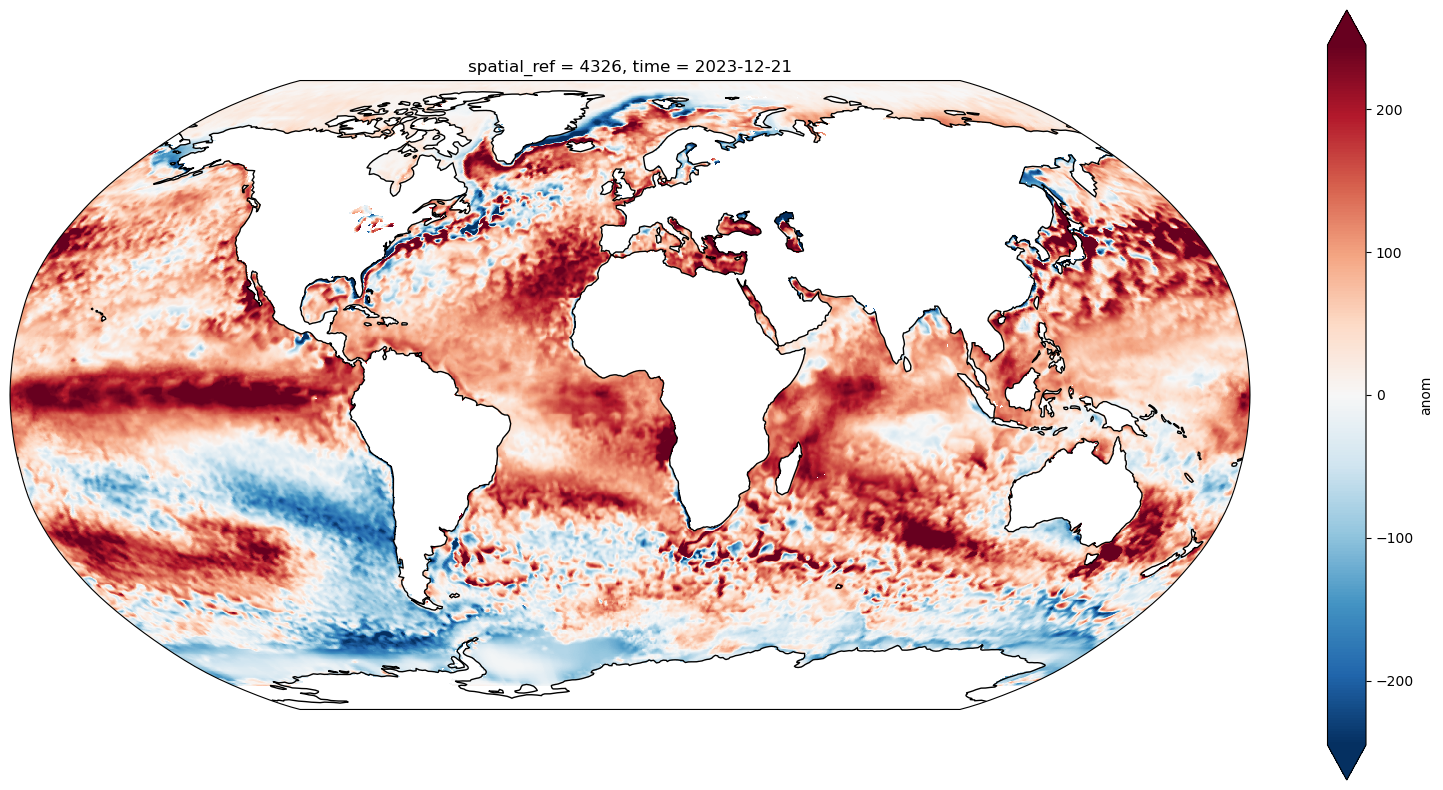

In [20]:
fig, ax = plt.subplots(
    figsize=(20, 10),
    subplot_kw=dict(projection=ccrs.Robinson())
)

oisst.anom.isel(time=-1).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    robust=True
)
ax.coastlines();

Or we can quickly get a timeseries of the global average (over latitude and longitude) of the sea surface temperature.

CPU times: user 2.7 s, sys: 275 ms, total: 2.98 s
Wall time: 16.4 s


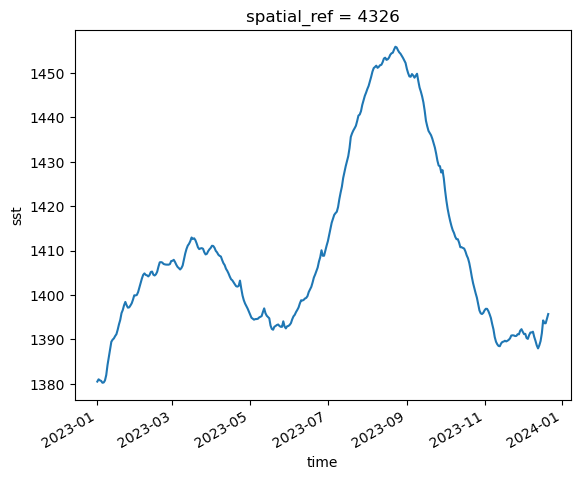

In [21]:
# should take ~15 seconds
%time ts = oisst.sst.mean(dim=("latitude", "longitude")).compute()
ts.plot();

## Operational forecast data

The Planetary Computer also includes some operational weather forecast data. These are typically stored as Zarr or GRIB2. In this example we'll load some data from the ECMWF's Open Data program (using the staging API. It'll be available through the production API soon)

In [22]:
search = catalog.search(
    collections=["ecmwf-forecast"],
    datetime="2023-12-01T00:00:00/2024-01-01T00:00:00",
    query={
        "ecmwf:stream": {"eq": "wave"},
        "ecmwf:type": {"eq": "fc"},
        "ecmwf:step": {"eq": "0h"},
    },
)
items = search.item_collection()
item = items[0]
item

<Item id=ecmwf-2024-01-01T00-wave-fc-0h>

The GRIB2 file and libraries for working with it also aren't that cloud-friendly. We're working on that, but in the meantime we'll download the file to disk and load it from there. Again into an `xarray.DataArray`.

In [23]:
url = item.assets["data"].href
filename, _ = urllib.request.urlretrieve(url)

ds = xr.open_dataset(filename, engine="cfgrib")
ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    mwd         (latitude, longitude) float32 ...
    swh         (latitude, longitude) float32 ...
    mwp         (latitude, longitude) float32 ...
    pp1d        (latitude, longitude) float32 ...
    mp2         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-01-26T17:03 GRIB to CDM+CF via cfgrib-0.9.1...

Let's make another plot, this time for "significant wave height".

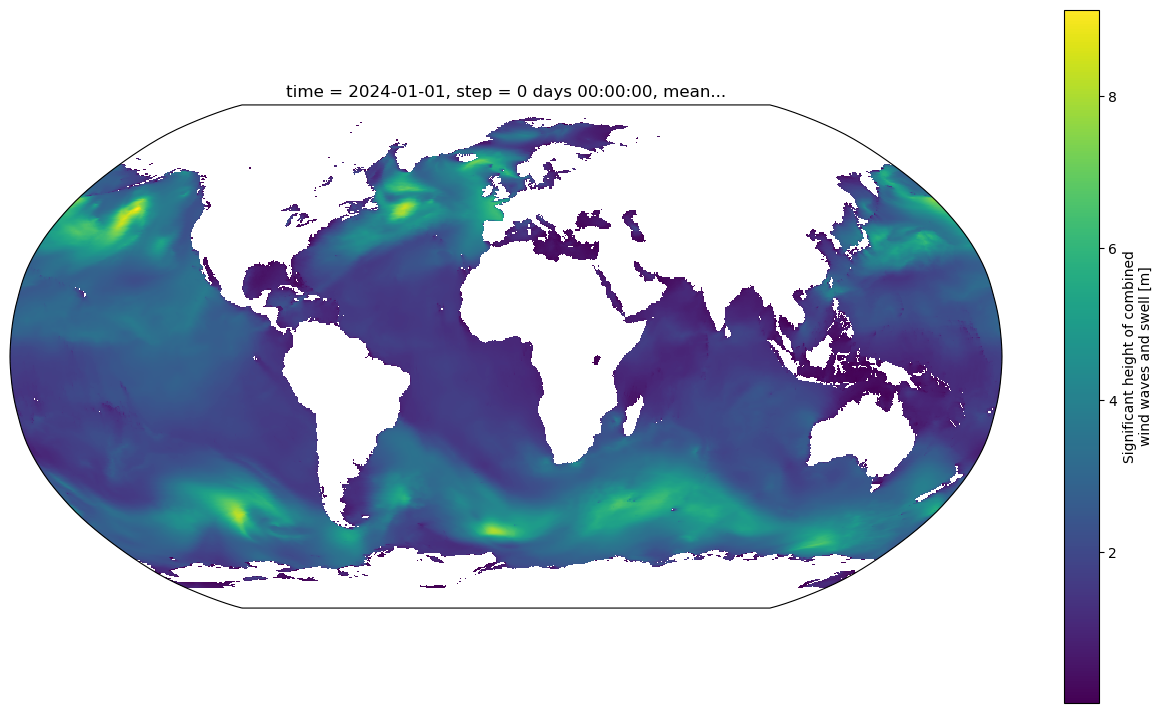

In [24]:
projection = projection = ccrs.Robinson()
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=projection))

ds.swh.plot(ax=ax, transform=ccrs.PlateCarree());

This is an example of using a non-cloud optimized format (like GRIB2) from the cloud. It still works, by downloading the file locally like you would using the traditional model. You just don't get all the benefits of cloud optimized formats.

## Vector Geospatial Data

The Planetary Computer also hosts some tabular datasets with vector geospatial data.

These are typically stored in Apache Parquet, using the geoparquet standard where appropriate. Some examples include

- Microsoft Buildings Footprints
- US Census
- Forest Inventory and Analysis
- gNATSGO tables

In this example, we'll load up the 2020 Congressional District boundaries from the [US Census](https://planetarycomputer.microsoft.com/dataset/us-census) dataset.

In [25]:
search = catalog.search(collections=["us-census"])
items = search.item_collection()
items = {x.id: x for x in items}
item = items["2020-cb_2020_us_cd116_500k"]
item

<Item id=2020-cb_2020_us_cd116_500k>

That STAC item has a link a Parquet file in Blob Storage. We'll load it up with geopandas.

In [26]:
asset = item.assets["data"]
df = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df

STATEFP  CD116FP       AFFGEOID GEOID                   NAMELSAD LSAD  \
0        06       42  5001600US0642  0642  Congressional District 42   C2   
1        39        7  5001600US3907  3907   Congressional District 7   C2   
2        48        3  5001600US4803  4803   Congressional District 3   C2   
3        28        2  5001600US2802  2802   Congressional District 2   C2   
4        42       18  5001600US4218  4218  Congressional District 18   C2   
..      ...      ...            ...   ...                        ...  ...   
436      26        1  5001600US2601  2601   Congressional District 1   C2   
437      36        3  5001600US3603  3603   Congressional District 3   C2   
438      48       16  5001600US4816  4816  Congressional District 16   C2   
439      06       24  5001600US0624  0624  Congressional District 24   C2   
440      39        3  5001600US3903  3903   Congressional District 3   C2   

     CDSESSN        ALAND       AWATER  \
0        116   2424753563     44105315   
1        116  10010016396     64562455   
2        116   1245574011     97890112   
3        116  40278711117    951654563   
4        116    757655195     19985421   
..       ...          ...          ...   
436      116  64824859099  75781913171   
437      116    659986401    302111406   
438      116   1841189026      3570589   
439      116  17825148853   3683946407   
440      116    590740187     11279289   

                                              geometry  
0    POLYGON ((-117.67629 33.88882, -117.65488 33.8...  
1    MULTIPOLYGON (((-82.55933 40.78975, -82.55835 ...  
2    POLYGON ((-96.84410 32.98891, -96.84403 32.992...  
3    POLYGON ((-91.36371 31.78036, -91.35951 31.799...  
4    POLYGON ((-80.17834 40.33725, -80.17537 40.338...  
..                                                 ...  
436  MULTIPOLYGON (((-83.21216 45.05173, -83.21039 ...  
437  MULTIPOLYGON (((-73.76470 40.81160, -73.76435 ...  
438  POLYGON ((-106.64548 31.89867, -106.64084 31.9...  
439  MULTIPOLYGON (((-119.04704 33.48382, -119.0384...  
440  POLYGON ((-83.17385 39.97542, -83.17361 39.975...  

[441 rows x 10 columns]

The geospatial data is stored in the `geometry` column. In this case they're Polygons (or Multi-polygons) with the boundary of each congressional district.

We can quickly plot the districts for Maryland (with a state FIPS code of `24`).

In [27]:
maryland = df[df.STATEFP == "24"].astype({"GEOID": "category"})
maryland.explore(column="GEOID")

## Summary

In this notebook, we explored how to access data on the Planetary Computer. We used the STAC API to query for the data we cared about, filtering by space, time, and more.

Notice that we didn't have to think about *files* at all. We didn't need to parse any file paths, we didn't need to list directories. We relied on the STAC metadata and standard to efficiently search for the files we cared about.

As much as possible, we avoided downloading data to disk. We instead loaded the assets directly into memory. This takes advantage of the cloud-friendly properties of many of the file formats we used. In some cases, where we only read a subset of the data, we were able to avoid downloading large chunks of the file entirely.